In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from skimage import io, transform

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils
from torchvision.datasets import VisionDataset

REVIDE_PATH = os.path.join('REVIDE_inside')

/home/joshuaeh/anaconda3/envs/shac/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


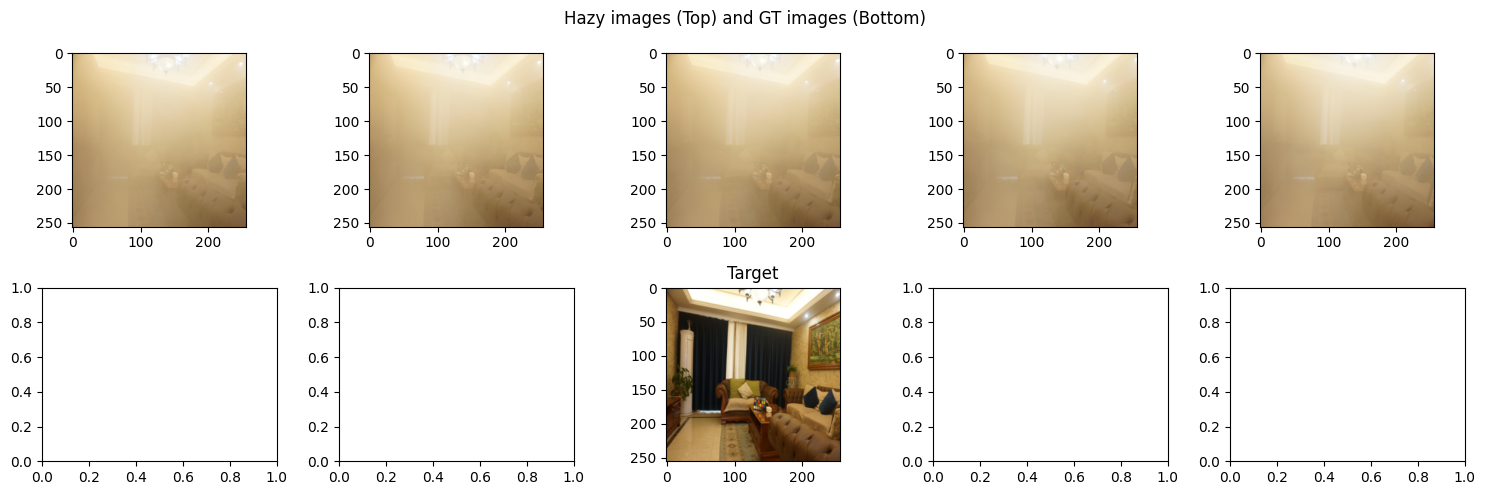

In [2]:
# Dimensions: [Batch size, 2,# images,  channels, height, width]

## Dataset
class REVIDE_inside(Dataset):
    """REVIDE Inside dataset."""

    def __init__(self, root_dir, n_frames, selected_scenes=None, transform=None):
        """
        Args:
            root_dir (string): Directory with all scenes.
            N_frames (int): Number of frames before and after the target frame
            scenes (list of strings): List of scenes to load. If None, all scenes are loaded.
                Other default options include:
                - 'C', 'E', 'J', 'L', 'W', will all result in only the scenes beginning with that letter
                - train, test, and validate will load one scene from each room for validate and test with the rest for training
                - trainV1, testV1, and validateV1 will load 3 all E, K, and W scenes for training (30), C for validation (8), and W for testing (8) 
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.n_frames = n_frames
        self.hazy_scenes_dir = os.path.join(root_dir, 'hazy')
        self.gt_scenes_dir = os.path.join(root_dir, 'gt')
        self.selected_scenes = self.map_scenes(selected_scenes)

        # create samples
        self.samples = []
        for scene in self.selected_scenes:
            scene_path = os.path.join(self.hazy_scenes_dir,scene)
            scene_images = os.listdir(scene_path)
            n_scene_images = len(scene_images)
            if n_scene_images > 2*n_frames:
                scene_segments = 0
                while scene_segments < n_scene_images - 2*n_frames:
                    sample = {} 
                    image_names = [f"{i:05}.JPG" for i in range(scene_segments,scene_segments+2*n_frames+1)]
                    sample['hazy image paths'] = [os.path.join(scene_path,image_name) for image_name in image_names]
                    sample['gt image paths'] = [os.path.join(os.path.join(self.gt_scenes_dir,scene),image_name) for image_name in image_names]
                    self.samples.append(sample)
                    scene_segments += 1
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.samples[idx]
        hazy_images = [io.imread(path) for path in sample['hazy image paths']]
        gt_images = [io.imread(path) for path in sample['gt image paths']]
        sample = {'hazy images': hazy_images, 'gt images': gt_images}

        if self.transform:
            sample['hazy images'] = [self.transform(img) for img in sample['hazy images']]
            sample['gt images'] = [self.transform(img) for img in sample['gt images']]

        # sample['hazy images'] = torch.Tensor(sample['hazy images'])
        # sample['gt images'] = torch.Tensor(sample['gt images'])

        return sample

    def display_sample(self, idx=None):
        if idx is None:
            idx = np.random.randint(0,len(self.samples))
        sample = self.__getitem__(idx)
        hazy_images = sample['hazy images']
        gt_images = sample['gt images']
        if type(hazy_images[0])==torch.Tensor:
            hazy_images = [img.permute(1,2,0) for img in hazy_images]
            gt_images = [img.permute(1,2,0) for img in gt_images]
        fig, axs = plt.subplots(2, 2*self.n_frames+1, figsize=(15, 5))
        fig.suptitle('Hazy images (Top) and GT images (Bottom)')
        for i in range(2*self.n_frames+1):
            axs[0,i].imshow(hazy_images[i])
            if i == self.n_frames:
                axs[1,i].set_title('Target')
                axs[1,i].imshow(gt_images[i])
        fig.tight_layout()
        plt.show()
    
    def map_scenes(self, input_scenes):
        """
        Returns a list of scenes based on the scenes initialization argument
        """
        # TODO cases in Python 3.10 would be nice here
        if input_scenes is None:
            return os.listdir(self.hazy_scenes_dir)
        elif type(input_scenes) == list:
            # check that all listed scenes are valid
            if set(input_scenes).issubset(set(os.listdir(self.hazy_scenes_dir))):
                return input_scenes
            else:
                raise ValueError('Invalid scene name(s) provided')
        elif type(input_scenes) == str:
            # Individual rooms
            if input_scenes.lower() in ['c', 'e', 'j', 'l', 'w'] and len(input_scenes) == 1:
                return [scene for scene in os.listdir(self.hazy_scenes_dir) if scene[0] == input_scenes]

            # train-test-validate splits
            elif input_scenes.lower() == "train":
                return ['C002_1', 'C002_2', 'C002_3', 'C002_4', 'C006_1', 'C006_2', 'E001', 'E001_2', 'E002',
                    'E002_1', 'E003', 'E003_1', 'E003_2', 'E004', 'E007', 'E009', 'J002_1', 'J002_2', 'J005_1',
                    'J005_2', 'L002_1', 'L002_2', 'L003_1', 'L003_2', 'L004_1', 'L004_2', 'L005_1', 'L007_1', 
                    'L007_2', 'L008_2', 'W001_1', 'W001_2', 'W003_1', 'W003_2', 'W005_1', 'W005_2', 'W006', 'W007']
            elif input_scenes.lower() == "validate":
                return ['C003', 'E005', 'J006', 'L008_1', 'W004']
            elif input_scenes.lower() == "test":
                return ['C005', 'E006', 'J004', 'L006', 'W002']

            # train-test-validate based on rooms
            elif input_scenes.lower() == "trainv1":
                return ['E001', 'E001_2', 'E002', 'E002_1', 'E003', 'E003_1', 'E003_2', 'E004', 'E005', 'E006', 
                'E007', 'E009', 'J002_1', 'J002_2', 'J004', 'J005_1', 'J005_2', 'J006', 'L002_1', 'L002_2', 'L003_1', 
                'L003_2', 'L004_1', 'L004_2', 'L005_1', 'L006', 'L007_1', 'L007_2', 'L008_1', 'L008_2']
            elif input_scenes.lower() == "validatev1":
                return ['C002_1', 'C002_2', 'C002_3', 'C002_4', 'C003', 'C005', 'C006_1', 'C006_2']
            elif input_scenes.lower() == "testv1":
                return ['W001_1', 'W001_2', 'W002', 'W003_1', 'W003_2', 'W004', 'W005_1', 'W005_2', 'W006', 'W007']
        else:
            raise ValueError('Invalid selected_scenes argument')

        

data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256,256)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                      std=[0.229, 0.224, 0.225])
                             
    ])

train_dataset = REVIDE_inside(REVIDE_PATH, 2, selected_scenes='trainv1', transform=data_transform)
test_dataset = REVIDE_inside(REVIDE_PATH, 2, selected_scenes='validatev1', transform=data_transform)
train_dataset.display_sample()

train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=0)

['C002_1', 'C002_2', 'C002_3', 'C002_4', 'C003', 'C005', 'C006_1', 'C006_2', 'E001', 'E001_2', 'E002', 'E002_1', 'E003', 'E003_1', 'E003_2', 'E004', 'E005', 'E006', 'E007', 'E009', 'J002_1', 'J002_2', 'J004', 'J005_1', 'J005_2', 'J006', 'L002_1', 'L002_2', 'L003_1', 'L003_2', 'L004_1', 'L004_2', 'L005_1', 'L006', 'L007_1', 'L007_2', 'L008_1', 'L008_2', 'W001_1', 'W001_2', 'W002', 'W003_1', 'W003_2', 'W004', 'W005_1', 'W005_2', 'W006', 'W007']
